In [1]:
import pickle
import pandas as pd

In [2]:
cr_df = pd.read_pickle('../pickle_jar/CritRole.pkl')
cr_df.head()
#I don't like the periods in these column names so I'm changing them

,name,text,ts.h,ts.m,ts.s,episode
0,MATT,We've got some cool stuff to talk about. First...,0,0,15,1
1,LAURA,As in nnnn.,0,1,21,1
2,MATT,"Nnnn. But yeah, so they're going to be a long-...",0,1,24,1
3,TRAVIS,(vomiting noises) Would you like some?,0,2,4,1
4,MATT,"So yeah. I'm super excited to have that, guys....",0,2,7,1


In [3]:
cr_df = cr_df.rename(columns={'ts.h': 'ts_h', 'ts.m': 'ts_m', 'ts.s': 'ts_s'})
cr_df.head()

,name,text,ts_h,ts_m,ts_s,episode
0,MATT,We've got some cool stuff to talk about. First...,0,0,15,1
1,LAURA,As in nnnn.,0,1,21,1
2,MATT,"Nnnn. But yeah, so they're going to be a long-...",0,1,24,1
3,TRAVIS,(vomiting noises) Would you like some?,0,2,4,1
4,MATT,"So yeah. I'm super excited to have that, guys....",0,2,7,1


In [4]:
cr_df["ts_h"] = cr_df["ts_h"].astype(str)
cr_df["ts_h"] = cr_df["ts_h"].str.zfill(2)
cr_df["ts_m"] = cr_df["ts_m"].astype(str)
cr_df["ts_m"] = cr_df["ts_m"].str.zfill(2)
cr_df["ts_s"] = cr_df["ts_s"].astype(str)
cr_df["ts_s"] = cr_df["ts_s"].str.zfill(2)

When looking at the timestamps in a typical timestamp format, 0:0:15 and 0:2:7 is unpleasant to look at and inconsistent, so i added in a leading 0 if the number in the column is less than 2 digits so that I can aggregate them and create the much easier to read 00:00:15 00:02:07 format. 

This will be helpful when I want to look at crosstalk or overlapping speech. Note that crosstalk is the language I've heard used in production spaces for overlapping speech and I know it's something they do their best to avoid *because* they are a production being recorded and aired. Too much speech at once would be difficult for viewers to parse and follow the ongoing story. It happens, though, as I explore later on in this notebook.

In [5]:
cr_df['timestamp'] = cr_df[['ts_h', 'ts_m', 'ts_s']].agg(':'.join, axis=1)

In [6]:
cr_df.head()

,name,text,ts_h,ts_m,ts_s,episode,timestamp
0,MATT,We've got some cool stuff to talk about. First...,00,00,15,1,00:00:15
1,LAURA,As in nnnn.,00,01,21,1,00:01:21
2,MATT,"Nnnn. But yeah, so they're going to be a long-...",00,01,24,1,00:01:24
3,TRAVIS,(vomiting noises) Would you like some?,00,02,04,1,00:02:04
4,MATT,"So yeah. I'm super excited to have that, guys....",00,02,07,1,00:02:07


In [7]:
cr_df = cr_df.drop(columns=['ts_h', 'ts_m', 'ts_s'])
cr_df.head()
#much better looking in my opinion

,name,text,episode,timestamp
0,MATT,We've got some cool stuff to talk about. First...,1,00:00:15
1,LAURA,As in nnnn.,1,00:01:21
2,MATT,"Nnnn. But yeah, so they're going to be a long-...",1,00:01:24
3,TRAVIS,(vomiting noises) Would you like some?,1,00:02:04
4,MATT,"So yeah. I'm super excited to have that, guys....",1,00:02:07


So I want to start exploring what the data looks like. I've noticed immediately at the tope of the data that not every instance in the "text" column is actual speech. How many instances do we have of this?

In [8]:
test = cr_df[cr_df['text'].str.contains('\)')]
test

,name,text,episode,timestamp
3,TRAVIS,(vomiting noises) Would you like some?,1,00:02:04
5,SAM,(laughter),1,00:02:42
7,SAM,(laughter),1,00:04:35
14,LAURA,"(yells) Okay. Yes, I do. It's a new campaign, ...",1,00:06:13
16,LAURA,"So we released our teaser on socials, and ever...",1,00:06:24
...,...,...,...,...
2689,MATT,"(chuckling) You say that now, wait till next w...",99,03:46:13
2702,MATT,(cheering),99,03:46:36
2714,TRAVIS,Both sides would be like. (groaning),99,03:47:11
2725,MATT,(cheering),99,03:47:52


So the thing is that text in parenthesis isn't speech! It shouldn't be tokenized or included in data about speech events. I also spotted some lines marked [no audio] so I'll look into those too.

--talked to Na-Rae, new goal to separate into two columns, one for "sounds" and one for "speech"

In [9]:
allnames = cr_df['name'].value_counts()
print(len(allnames))
allnames[0:15]

394


MATT        111729
LAURA        59987
SAM          52150
TRAVIS       49852
MARISHA      49278
LIAM         41441
TALIESIN     40530
ASHLEY       17660
MICA          1548
ASHLY         1407
BRIAN         1324
ALLY           733
ALL            670
DEBORAH        540
KHARY          491
Name: name, dtype: int64

My next thought was about the number of speakers (and while I'm at it, how many speech events our speakers have). Unsurprisingly, our DM has the most speech events in general, but it's the most by so much! 

The next few are interesting.... Sam and Laura both tend to be the ones doing opening show announcements (what's new with the company, new merch etc) and ad reads, so I'm not surprised they're higher than the rest of the cast. Laura is an interesting one.... she was gone for a number of episodes this campaign for maternity leave but she also played a character who was a sort of hyperactive blabbermouth, so she must have really made up for lost time. 

Finally, Ashley having the fewest lines also makes sense to me. She's a regular in the show Blindspot and was filming out of state, and missed a big chunk of episodes. On top of that, her character was a bit stoic and awkward, so she wasn't much of a talker even when she was present.

In [10]:
allnames[-20:]

MARISHA, SAM, ASHLY               1
SAM, TALIESIN, MARISHA            1
SAM, MARISHA, ASHLY               1
ASHLY, LIAM, SAM                  1
II                                1
LIAM, MARISHA, SAM                1
TALIESIN, MARISHA, LAURA          1
MARISHA, SUMALEE                  1
SUMALEE, MATT                     1
LIAM, ASHLY                       1
ASHLY, MARISHA, SUMALEE           1
NILA                              1
AUDIENCE, BRIAN                   1
ASHLY, MATT, AUDIENCE             1
MARISHA, MATT, AUDIENCE           1
ASHLY, LIAM, AUDIENCE             1
ASHLY, AUDIENCE                   1
TRAVIS, MARISHA, MATT             1
MARISHA, TALIESIN, LAURA          1
LAURA, TALIESIN, LIAM, MARISHA    1
Name: name, dtype: int64

In [11]:
cr_df[cr_df['name']=='SAM, TALIESIN, MARISHA']

,name,text,episode,timestamp
1654,"SAM, TALIESIN, MARISHA",Whispers?,26,02:11:37


In [12]:
cr_df[cr_df['name']=='TALIESIN, MARISHA, LAURA']

,name,text,episode,timestamp
74,"TALIESIN, MARISHA, LAURA",Not it.,31,00:11:09


I wanted to explore and take a look at an instance of overlapping speech I remembered from when I was watching (highlights, these episodes are too long for me) this campaign. At the end of episode 2, two characters (played by our talkative Laura and Sam) think they're onto the perpetrator of some crime, and are in this moment hurling accusations at that person (Ornna). 

They overlap *a lot* in this crazy buzz of a moment, and you can more or less see this in the transcripts, but it's not always 100% clear. These transcriptionists did a really thorough job though.

In [13]:
ep2 = cr_df[cr_df['episode']=='2']
ep2[-130:-120]

,name,text,episode,timestamp
2564,MATT,"At which point, the flap of the tent opens up ...",2,04:01:13
2565,LAURA,It's Ornna!,2,04:01:17
2566,SAM,"Ornna, you have a lot of explaining to do!",2,04:01:19
2567,MARISHA,Shut up!,2,04:01:20
2568,SAM,You have a lot of explaining to do!,2,04:01:21
2569,MARISHA,Shut up!,2,04:01:22
2570,SAM,We've talked to Toya. She knows it's you who d...,2,04:01:24
2571,LAURA,We know you guys are in a fight all the time.,2,04:01:28
2572,SAM,You're the one behind the whole plot! You did ...,2,04:01:30
2573,LAURA,You!,2,04:01:32


a link to the moment of chaos, just for comparison

https://youtu.be/MPELLuQXVcE?si=13too39HcHj5Cfow&t=14475

Now back to this goal of splitting (sounds) and speech into different columns.

In [14]:
cr_df[cr_df['text'].str.contains('^\(.*\)')]

,name,text,episode,timestamp
3,TRAVIS,(vomiting noises) Would you like some?,1,00:02:04
5,SAM,(laughter),1,00:02:42
7,SAM,(laughter),1,00:04:35
14,LAURA,"(yells) Okay. Yes, I do. It's a new campaign, ...",1,00:06:13
54,ASHLEY,(laughter),1,00:11:14
...,...,...,...,...
2665,MATT,(screaming),99,03:45:20
2689,MATT,"(chuckling) You say that now, wait till next w...",99,03:46:13
2702,MATT,(cheering),99,03:46:36
2725,MATT,(cheering),99,03:47:52


In [16]:
cr_df[cr_df['text'].str.contains('^\(.*\) $')]

,name,text,episode,timestamp
5,SAM,(laughter),1,00:02:42
7,SAM,(laughter),1,00:04:35
54,ASHLEY,(laughter),1,00:11:14
86,MATT,(nervous laughter),1,00:18:08
135,MATT,(laughter),1,00:27:49
...,...,...,...,...
2613,MARISHA,(laughter),99,03:40:38
2665,MATT,(screaming),99,03:45:20
2702,MATT,(cheering),99,03:46:36
2725,MATT,(cheering),99,03:47:52


This is good for at least the lines that are *just* sound and not combined sound/speech, which is good. I have to do some more reading about moving these specific lines to a new column for sounds but maintain their index space. 
I think I can do this by adding the new column and mapping the spplication of that new column onto the existing text column, but I'll take the time to experiment with that more this coming week to be sure of it. 

I'm not exactly ready to dig heavy into the stats yet but I want to do a little look for our progress report at least

In [17]:
ashley = cr_df[cr_df['name']=='ASHLEY']
matt = cr_df[cr_df['name']=='MATT']
marisha = cr_df[cr_df['name']=='MARISHA']
taliesin = cr_df[cr_df['name']=='TALIESIN']
sam = cr_df[cr_df['name']=='SAM']
liam = cr_df[cr_df['name']=='LIAM']
laura = cr_df[cr_df['name']=='LAURA']
travis = cr_df[cr_df['name']=='TRAVIS']

ashley

,name,text,episode,timestamp
50,ASHLEY,"Jeez Louise, Matt.",1,00:09:43
54,ASHLEY,(laughter),1,00:11:14
73,ASHLEY,Go check them out on Instagram!,1,00:16:09
309,ASHLEY,I didn't either.,1,00:44:57
316,ASHLEY,"Wait, did you say your name?",1,00:45:54
...,...,...,...,...
2558,ASHLEY,I'm going to keep trying it until I get it.,99,03:37:28
2560,ASHLEY,Thank you.,99,03:37:31
2640,ASHLEY,"Yeah, it's moving.",99,03:43:33
2668,ASHLEY,A dragon turtle?,99,03:45:33


In [33]:
women = [ashley, marisha, laura]
women_df = pd.concat(women)
women_df

,name,text,episode,timestamp
50,ASHLEY,"Jeez Louise, Matt.",1,00:09:43
54,ASHLEY,(laughter),1,00:11:14
73,ASHLEY,Go check them out on Instagram!,1,00:16:09
309,ASHLEY,I didn't either.,1,00:44:57
316,ASHLEY,"Wait, did you say your name?",1,00:45:54
...,...,...,...,...
2690,LAURA,"We would have fought that today, potentially?",99,03:46:15
2695,LAURA,I tried to scry on my Traveler.,99,03:46:25
2708,LAURA,Look at that.,99,03:46:59
2716,LAURA,Wow.,99,03:47:20


Glad I tried this, keep running into spots I'm finding I need to read up on in detail that are important for my later work. What my vision here is to be able to split the cr_df by these groupings, but that may not be so simple as this. 

Thinking further... maybe from these sub-dfs I can just add a "gender" column and remap it onto the main df, that should get the job done at least. Another grouping I would like to do *maybe* is a catchall "other" for the guests and the instances of multiple speakers doesn't look like such a mess like in the chart below. 

<Axes: ylabel='name'>

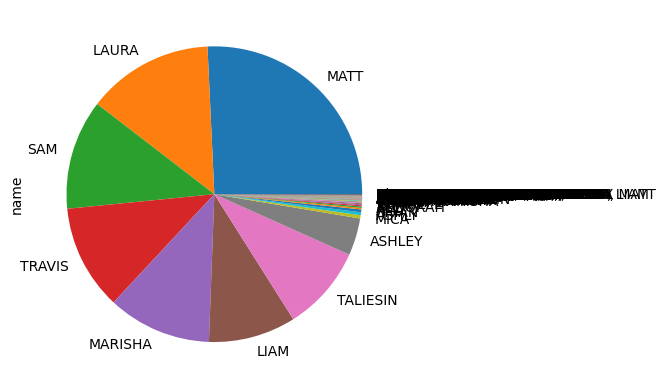

In [32]:
allnames.plot.pie()

Wow. Looking at the numbers was one thing, but this really puts it into another perspective. Matt really has a lot of talking to do. 